# Yield Prediction using RDkit Descriptor Oxadiazole

In [3]:
import warnings 
warnings.filterwarnings('ignore')
import pandas as pd 
import os 
import sys
import pickle
import numpy as np
from matplotlib import pyplot as plt
from rdkit.Chem.AllChem import MolFromSmiles, MolFromSmarts
from rdkit.ML.Descriptors.Descriptors import DescriptorCalculator
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit import Chem
from rdkit.Chem import AllChem
from drfp import DrfpEncoder
import shap
import cairo
import pandas as pd
import seaborn as sns
IPythonConsole.molSize = (300, 300)
from scipy import stats
from scipy.stats import skew
from scipy.stats import norm
from scipy.special import boxcox1p
shap.initjs()

## Data

In [11]:
data = r"C:\Users\loris\Desktop\IA_chemistry\Dipyrromethanes_condensation_reactions-main\Condensation_reactions - Copie.xlsx"
dataF = pd.read_excel(data)

df = dataF.copy()

df.shape

(1249, 4)

In [12]:
df.head()

,SMILES,yield,Temperature,Ind
0,CC(C)(C)c1ccc(OCCCCOc2ccc(C(C)(C)C)cc2C=O)c(C=...,0.05,20,78
1,O=Cc1ccccc1OCCOC(=O)C#CC(=O)OCCOc1ccccc1C=O.c1...,1.00,40,909
2,c1cc[nH]c1.Cc1cc(C)c(C=O)c(C)c1.COC(=O)c1ccc(C...,2.00,20,747
3,CC(C)(C)c1ccc(OCCCCCOc2ccc(C(C)(C)C)cc2C=O)c(C...,2.10,20,77
4,Cc1ccc(-c2ccccc2C=O)cc1.Fc1c(F)c(F)c(C(c2ccc[n...,2.50,25,266


In [13]:
df.columns

Index(['SMILES', 'yield', 'Temperature', 'Ind'], dtype='object')

In [14]:
for col in df.columns:
    print(len(df[col].unique()) == 1)

False
False
False
False


In [15]:
result_dict = {}  # Dictionnaire pour stocker les résultats

for col in df.columns:
    result_dict[col] = len(df[col].unique()) == 1

# Créer un DataFrame à partir du dictionnaire
result_df = pd.DataFrame(list(result_dict.items()), columns=['Nom de la colonne', 'Valeur unique'])

print(result_df)


  Nom de la colonne  Valeur unique
0            SMILES          False
1             yield          False
2       Temperature          False
3               Ind          False


## Missing values

In [16]:
missing_values = df.isna().sum() 
missing_values

SMILES         0
yield          0
Temperature    0
Ind            0
dtype: int64

In [17]:
missing_values_per = (df.isna().sum() /len(df))*100
missing_values_per.sort_values()

SMILES         0.0
yield          0.0
Temperature    0.0
Ind            0.0
dtype: float64

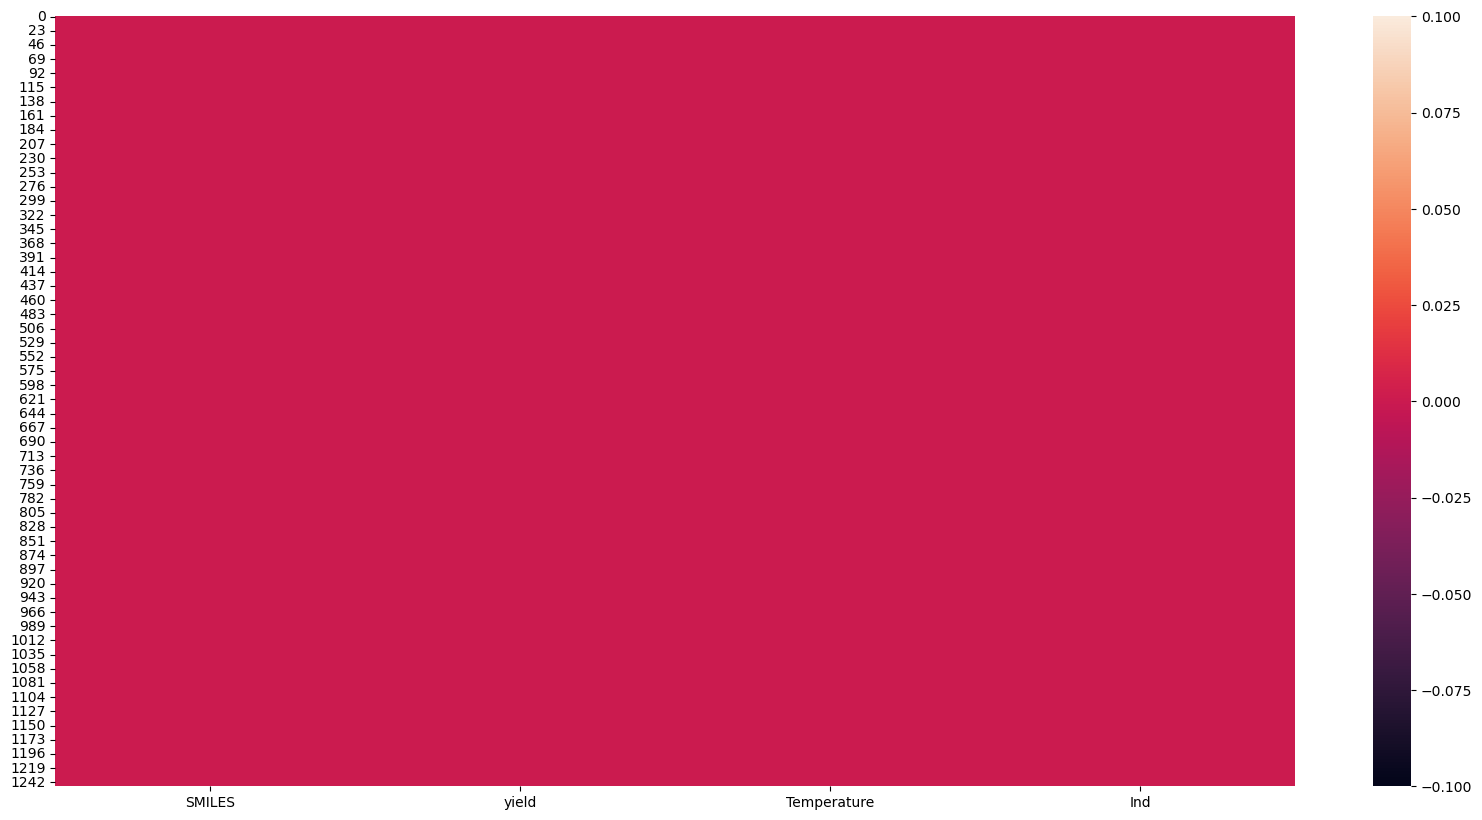

In [18]:
plt.figure(figsize=(20,10))
sns.heatmap(df.isna());

## target

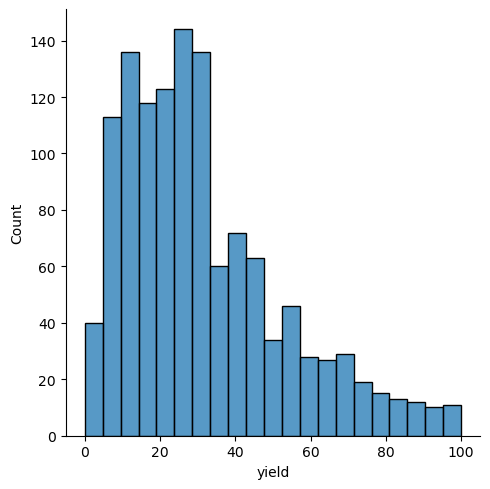

In [26]:
sns.displot(df["yield"]);

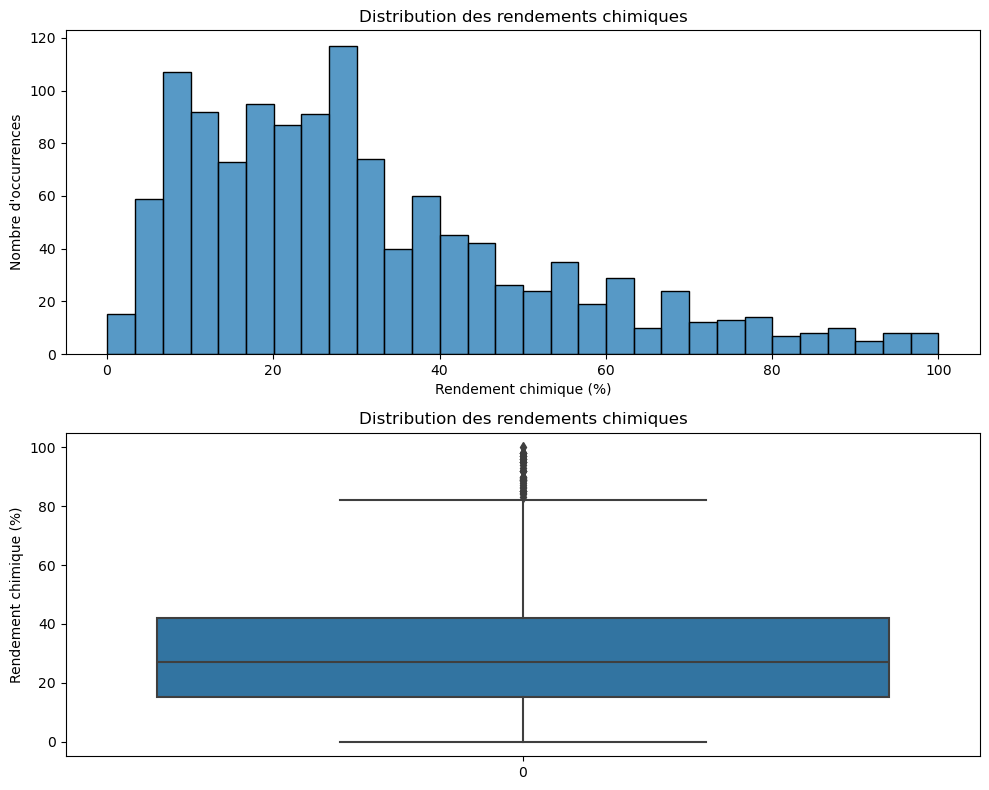

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Création de la figure et des axes pour les subplots
fig, axs = plt.subplots(2,1, figsize=(10,8))

# Tracé de l'histogramme sur le premier subplot
sns.histplot(data=df, x="yield", bins=30, ax=axs[0])
axs[0].set_xlabel('Rendement chimique (%)')
axs[0].set_ylabel("Nombre d\'occurrences")
axs[0].set_title('Distribution des rendements chimiques')

# Tracé du boxplot sur le deuxième subplot
sns.boxplot(df["yield"], ax=axs[1])
axs[1].set_ylabel('Rendement chimique (%)')
axs[1].set_title('Distribution des rendements chimiques')

# Ajustement de l'espacement entre les subplots
plt.tight_layout()

# Affichage des graphiques
plt.show()


## Prendre uniquement 200 points

In [31]:
sampled_df = df.sample(n=200, random_state=42)

In [32]:
sampled_df.head()

,SMILES,yield,Temperature,Ind
679,C.C.N.Cc1c[nH]c(C)c1.CCOCC.FB(F)F.O=C(Cl)c1ccc...,29.0,20,421
1050,C.C.N.Cc1c[nH]c(C)c1.CCOCC.FB(F)F.O=Cc1ccc(OCc...,54.0,25,365
901,C.C.N.CCCCC(=O)Cl.Cc1c[nH]c(C)c1.CCOCC.FB(F)F....,40.0,80,535
243,CCCCCCc1c(C)c[nH]c1Cc1[nH]cc(C)c1CCCCCC.CCCCCC...,12.1,27,139
328,Cn1ccnc1C=O.COC(=O)c1ccc(C(c2ccc[nH]2)c2ccc[nH...,16.0,20,315


In [33]:
sampled_df.shape

(200, 4)

In [23]:
Valeur_non_juste = df[df['Catalyst_precursor'] == 'Pd(OAc)3']
Valeur_non_juste

,Substrate,Substrate_Eq,Substrate_mmol,Coupling_partner,Coupling_partner_Eq,Base,Base_Eq,Solvent,Solvent_Conc,temperature,...,Catalyst_precursor,Catalyst_precursor_Eq,Catalyst_precursor_2,Catalyst_precursor_2_Eq,Ligand,Ligand_Eq,Product,Analytical_yield (NMR),DOI,Origin
62,COC(C=C1)=CC=C1C2=NN=CO2,1,0.5,ClC1=CC=C(F)C=C1,2,C(=O)([O-])[O-].[Cs+].[Cs+],2.0,CC1=CC=CC=C1,0.1,100,...,Pd(OAc)3,1.01,,0,CC(P(C12=[CH]3[C-]4(C(C)(C)C)[CH]5=[CH]1[Fe+2]...,0.02,FC(C=C1)=CC=C1C2=NN=C(O2)C3=CC=C(OC)C=C3,7.0,10.1002/ejoc.202400212,Optimization


In [24]:
df["Catalyst_precursor"].replace("Pd(OAc)3","CC(=O)[O-].CC(=O)[O-].[Pd+2]", inplace=True)

In [39]:
import re
def nettoyer_reactions(chimique_reaction):
    # Utilise une expression régulière pour remplacer les occurrences de plusieurs points par un seul point
    chimique_reaction = re.sub(r'\.{2,}', '.', chimique_reaction)
    # Supprime les points au début et à la fin de la chaîne
    chimique_reaction = chimique_reaction.strip()
    chimique_reaction = re.sub(r'^\.', '', chimique_reaction)
    chimique_reaction = re.sub(r'\.$', '', chimique_reaction)
    return chimique_reaction

In [40]:
df["Chemical_Reaction"] = df["Chemical_Reaction"].apply(nettoyer_reactions)

In [41]:
df["Chemical_Reaction"][50]

'COC(C=C1)=CC=C1C2=NN=CO2.ClC1=CC=C(F)C=C1.C(=O)([O-])[O-].[Cs+].[Cs+].O=CN(C)C.CC(=O)[O-].CC(=O)[O-].[Pd+2].C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=CC=CC=C3>>FC(C=C1)=CC=C1C2=NN=C(O2)C3=CC=C(OC)C=C3'

In [42]:
df["Chemical_Reaction"][106]

'ClC1=CC=C(C(F)(F)F)C=C1.C(=O)([O-])[O-].[Cs+].[Cs+].O=CN(C)C.CC(=O)[O-].CC(=O)[O-].[Pd+2].CC(P(C12=[CH]3[C-]4(C(C)(C)C)[CH]5=[CH]1[Fe+2]35246789[CH]%10=[CH]6[C-]7(C(C)(C)C)[CH]8=C%109P(C(C)C)C(C)C)C(C)C)C>>ClC1=CC=C(C2=NN=C(C3=CC=C(C(F)(F)F)C=C3)O2)C=C1'

In [43]:
df.head()

,Substrate,Coupling_partner,Base,Base_Eq,Solvent,Catalyst_precursor,Catalyst_precursor_Eq,Catalyst_precursor_2,Catalyst_precursor_2_Eq,Ligand,Ligand_Eq,Product,Analytical_yield (NMR),DOI,Origin,Chemical_Reaction
0,FC(C=CC=C1)=C1C2=NN=CO2,IC1=CC=C(OC)C=C1,C(=O)([O-])[O-].[Cs+].[Cs+],2.0,C1COCCO1,CC(=O)[O-].CC(=O)[O-].[Pd+2],0.05,[Cu+].[I-],0.1,C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=CC=CC=C3,0.1,FC1=C(C2=NN=C(C3=CC=C(OC)C=C3)O2)C=CC=C1,96.0,,Optimization,FC(C=CC=C1)=C1C2=NN=CO2.IC1=CC=C(OC)C=C1.C(=O)...
1,FC(C=CC=C1)=C1C2=NN=CO2,IC1=CC=C(OC)C=C1,C(=O)([O-])[O-].[Cs+].[Cs+],2.0,C1COCCO1,CC(=O)[O-].CC(=O)[O-].[Pd+2],0.05,[Cu+].[I-],0.1,C=1C=CC(=CC1)P(C=2C=CC=CC2)C=34[CH]5=[CH]6[C-]...,0.1,FC1=C(C2=NN=C(C3=CC=C(OC)C=C3)O2)C=CC=C1,86.0,,Optimization,FC(C=CC=C1)=C1C2=NN=CO2.IC1=CC=C(OC)C=C1.C(=O)...
2,FC(C=CC=C1)=C1C2=NN=CO2,IC1=CC=C(OC)C=C1,C(=O)([O-])[O-].[Cs+].[Cs+],2.0,C1COCCO1,CC(=O)[O-].CC(=O)[O-].[Pd+2],0.05,[Cu+].[I-],0.1,CC(P(C12=[CH]3[C-]4(C(C)(C)C)[CH]5=[CH]1[Fe+2]...,0.1,FC1=C(C2=NN=C(C3=CC=C(OC)C=C3)O2)C=CC=C1,99.0,,Optimization,FC(C=CC=C1)=C1C2=NN=CO2.IC1=CC=C(OC)C=C1.C(=O)...
3,FC(C=CC=C1)=C1C2=NN=CO2,IC1=CC=C(OC)C=C1,C(=O)([O-])[O-].[Cs+].[Cs+],2.0,C1COCCO1,CC(=O)[O-].CC(=O)[O-].[Pd+2],0.05,[Cu+].[I-],0.1,CC(C)(C)[C-]1([CH]2=C34P(C5CCCCC5)C6CCCCC6)[CH...,0.1,FC1=C(C2=NN=C(C3=CC=C(OC)C=C3)O2)C=CC=C1,97.0,,Optimization,FC(C=CC=C1)=C1C2=NN=CO2.IC1=CC=C(OC)C=C1.C(=O)...
4,FC(C=CC=C1)=C1C2=NN=CO2,IC1=CC=C(OC)C=C1,C(=O)([O-])[O-].[Cs+].[Cs+],2.0,C1COCCO1,CC(=O)[O-].CC(=O)[O-].[Pd+2],0.05,[Cu+].[I-],0.1,CC(C)(C)[C-]1([CH]2=C34P(C5=CC=C(C)O5)C6=CC=C(...,0.1,FC1=C(C2=NN=C(C3=CC=C(OC)C=C3)O2)C=CC=C1,77.0,,Optimization,FC(C=CC=C1)=C1C2=NN=CO2.IC1=CC=C(OC)C=C1.C(=O)...


In [44]:
df.head()

,Substrate,Coupling_partner,Base,Base_Eq,Solvent,Catalyst_precursor,Catalyst_precursor_Eq,Catalyst_precursor_2,Catalyst_precursor_2_Eq,Ligand,Ligand_Eq,Product,Analytical_yield (NMR),DOI,Origin,Chemical_Reaction
0,FC(C=CC=C1)=C1C2=NN=CO2,IC1=CC=C(OC)C=C1,C(=O)([O-])[O-].[Cs+].[Cs+],2.0,C1COCCO1,CC(=O)[O-].CC(=O)[O-].[Pd+2],0.05,[Cu+].[I-],0.1,C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=CC=CC=C3,0.1,FC1=C(C2=NN=C(C3=CC=C(OC)C=C3)O2)C=CC=C1,96.0,,Optimization,FC(C=CC=C1)=C1C2=NN=CO2.IC1=CC=C(OC)C=C1.C(=O)...
1,FC(C=CC=C1)=C1C2=NN=CO2,IC1=CC=C(OC)C=C1,C(=O)([O-])[O-].[Cs+].[Cs+],2.0,C1COCCO1,CC(=O)[O-].CC(=O)[O-].[Pd+2],0.05,[Cu+].[I-],0.1,C=1C=CC(=CC1)P(C=2C=CC=CC2)C=34[CH]5=[CH]6[C-]...,0.1,FC1=C(C2=NN=C(C3=CC=C(OC)C=C3)O2)C=CC=C1,86.0,,Optimization,FC(C=CC=C1)=C1C2=NN=CO2.IC1=CC=C(OC)C=C1.C(=O)...
2,FC(C=CC=C1)=C1C2=NN=CO2,IC1=CC=C(OC)C=C1,C(=O)([O-])[O-].[Cs+].[Cs+],2.0,C1COCCO1,CC(=O)[O-].CC(=O)[O-].[Pd+2],0.05,[Cu+].[I-],0.1,CC(P(C12=[CH]3[C-]4(C(C)(C)C)[CH]5=[CH]1[Fe+2]...,0.1,FC1=C(C2=NN=C(C3=CC=C(OC)C=C3)O2)C=CC=C1,99.0,,Optimization,FC(C=CC=C1)=C1C2=NN=CO2.IC1=CC=C(OC)C=C1.C(=O)...
3,FC(C=CC=C1)=C1C2=NN=CO2,IC1=CC=C(OC)C=C1,C(=O)([O-])[O-].[Cs+].[Cs+],2.0,C1COCCO1,CC(=O)[O-].CC(=O)[O-].[Pd+2],0.05,[Cu+].[I-],0.1,CC(C)(C)[C-]1([CH]2=C34P(C5CCCCC5)C6CCCCC6)[CH...,0.1,FC1=C(C2=NN=C(C3=CC=C(OC)C=C3)O2)C=CC=C1,97.0,,Optimization,FC(C=CC=C1)=C1C2=NN=CO2.IC1=CC=C(OC)C=C1.C(=O)...
4,FC(C=CC=C1)=C1C2=NN=CO2,IC1=CC=C(OC)C=C1,C(=O)([O-])[O-].[Cs+].[Cs+],2.0,C1COCCO1,CC(=O)[O-].CC(=O)[O-].[Pd+2],0.05,[Cu+].[I-],0.1,CC(C)(C)[C-]1([CH]2=C34P(C5=CC=C(C)O5)C6=CC=C(...,0.1,FC1=C(C2=NN=C(C3=CC=C(OC)C=C3)O2)C=CC=C1,77.0,,Optimization,FC(C=CC=C1)=C1C2=NN=CO2.IC1=CC=C(OC)C=C1.C(=O)...


## Fingerprint DRFP

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [48]:
X, mapping = DrfpEncoder.encode(df["SMILES"].values, mapping=True, n_folded_length=2048, radius=3, rings=True)

In [49]:
X = np.asarray(X, dtype=np.float32)
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [50]:
X.shape

(1249, 2048)

In [51]:
target = df['yield'] / 100 

In [52]:
target

0       0.0005
1       0.0100
2       0.0200
3       0.0210
4       0.0250
         ...  
1244    0.9800
1245    0.9800
1246    0.9800
1247    0.9800
1248    1.0000
Name: yield, Length: 1249, dtype: float64

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=42)

In [54]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(999, 2048)
(250, 2048)
(999,)
(250,)


In [69]:
# Entraînement du modèle de forêt aléatoire
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred = model.predict(X_test)


In [70]:
# Évaluation du modèle
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Absolute Error: 0.10645697725173141
Mean Squared Error: 0.020943719861309704
R^2 Score: 0.5833642464279818


Mean Squared Error: 0.020943719861309704
R-squared: 0.5833642464279818
Root Mean Squared Error: 0.14471945225611416


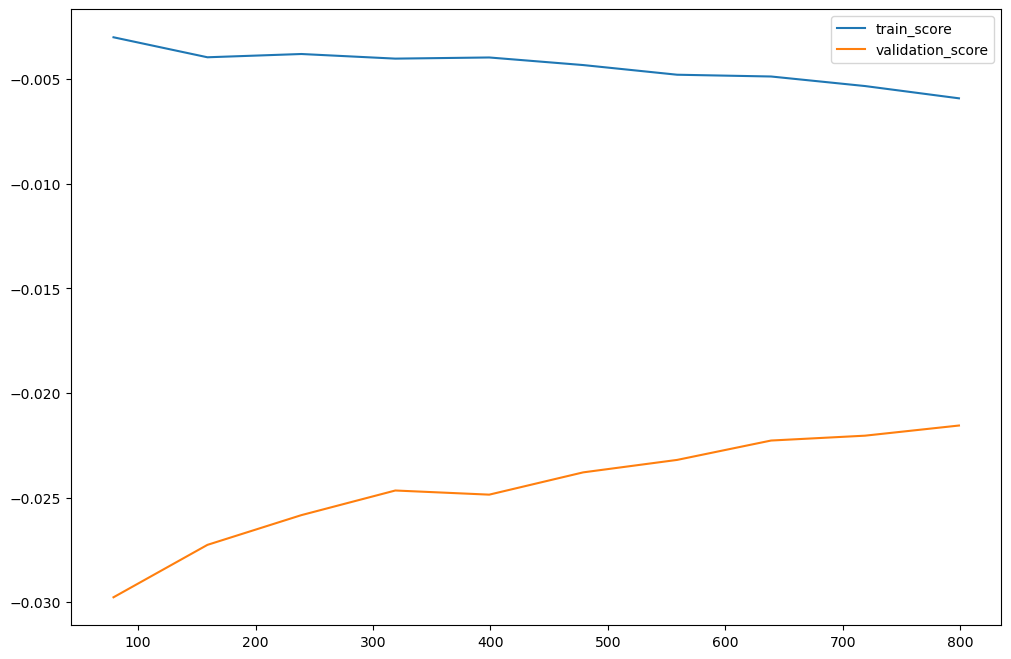

In [71]:
evaluation(model)

In [55]:
from sklearn.model_selection import GridSearchCV

# Paramètres à tester
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# Création du modèle avec recherche sur grille
grid_search = GridSearchCV(estimator=RandomForestRegressor(n_estimators=1000, random_state=42),
                           param_grid=param_grid, cv=5, verbose=2, scoring='neg_mean_squared_error')

# Entraînement avec recherche sur grille
grid_search.fit(X_train, y_train)

# Meilleurs paramètres et score
print("Best parameters:", grid_search.best_params_)
print("Best score (MSE):", -grid_search.best_score_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[C

## XGboost

In [57]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, r2_score
from sklearn.model_selection import learning_curve

In [66]:
model = XGBRegressor(
                n_estimators=200,
                learning_rate=0.01,
                max_depth=12,
                min_child_weight=6,
                colsample_bytree=0.6,
                subsample=0.8,
                random_state=42,
            )

In [67]:
def evaluation(model):
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print("Mean Squared Error:", mse)
    print("R-squared:", r2)
    print("Root Mean Squared Error:", rmse) 
    
    N, train_score, val_score = learning_curve(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1,1,10))
    
    plt.figure(figsize=(12,8))
    plt.plot(N, train_score.mean(axis=1), label='train_score')
    plt.plot(N, val_score.mean(axis=1), label='validation_score')
    plt.legend()
     

xgoost 2000 point
Mean Squared Error: 0.020806197025067478
R-squared: 0.5861000035375385
Root Mean Squared Error: 0.14424353373745208

Mean Squared Error: 0.02226718458071585
R-squared: 0.5570364152524707
Root Mean Squared Error: 0.14922193062923375


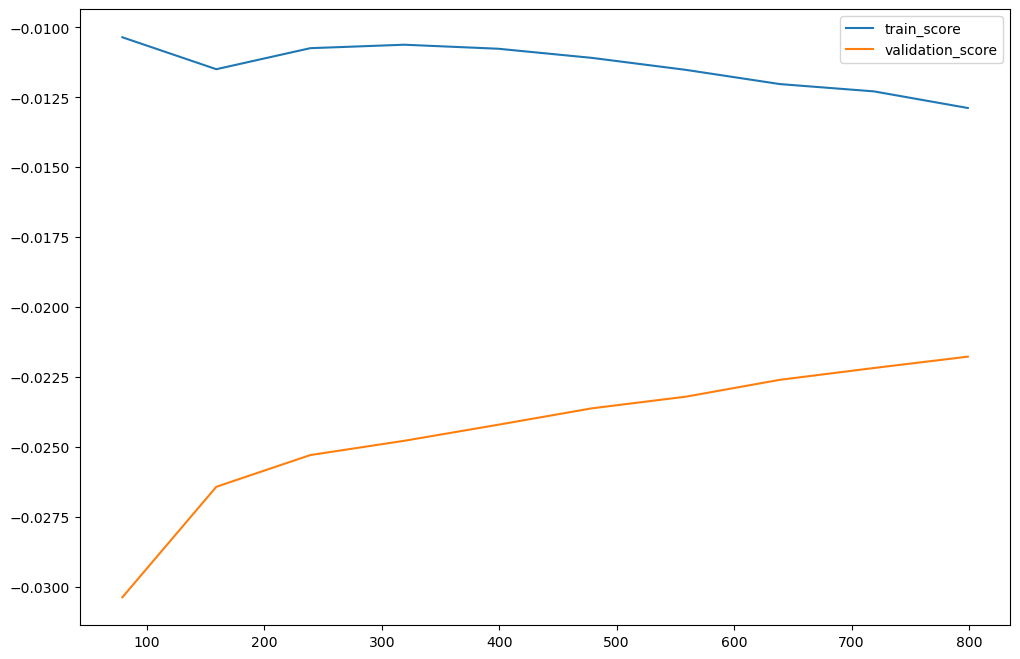

In [68]:
evaluation(model)

## test avec code de la publi Dipyrromethanes

In [89]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statistics import mean, stdev

In [76]:
y = target

In [77]:
y.shape

(1249,)

In [78]:
X.shape

(1249, 2048)

In [79]:
def random_forest_regression(X, y):
    rmse_scores = []
    r2_scores = []
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
        model = RandomForestRegressor(n_estimators=120, max_depth=25)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_scores.append(rmse)
        r2 = r2_score(y_test, y_pred)
        r2_scores.append(r2)
        #print(f"Iteration {i}: RMSE = {rmse:.3f}, R^2  = {r2:.3f}")
    print("\nAverage performance of test set at 10 split")
    print("Metric\tavg\tstdev")
    print("R^2\t%.2f\t%.2f" % (mean(r2_scores), stdev(r2_scores)))
    print("RMSE\t%.2f\t%.2f" % (mean(rmse_scores), stdev(rmse_scores)))

In [80]:
def statistics_for_the_training_set_with_5CV_RFR(X, y):
    r2_scores = []
    rmse_scores = []
    for i in range(10):
        X_tr, X_t, y_tr, y_t = train_test_split(X, y, test_size=0.2, random_state=i)
        X_tr.reset_index(drop=True , inplace=True)
        y_tr.reset_index(drop=True , inplace=True)
        cv = KFold(n_splits=5, shuffle=True, random_state=1)
        y_pred, y_true = [], []
        for train_index, test_index in cv.split(X_tr):
            X_train = X_tr.loc[train_index].values
            X_test = X_tr.loc[test_index].values
            y_train = y_tr.loc[train_index].values
            y_test = y_tr.loc[test_index].values
    
            model = RandomForestRegressor(n_estimators=120, max_depth=25)
            model.fit(X_train, y_train)
            y_pred.extend(model.predict(X_test))
            y_true.extend(y_test)

        r2_scores.append(metrics.r2_score(y_true, y_pred))
        rmse_scores.append(metrics.mean_squared_error(y_true, y_pred, squared=False))
      
    print("\nAverage performance of 5CV")
    print("Metric\tavg\tstdev")
    print("R^2\t%.2f\t%.2f" % (mean(r2_scores), stdev(r2_scores)))
    print("RMSE\t%.2f\t%.2f" % (mean(rmse_scores), stdev(rmse_scores))) 

In [91]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import pandas as pd
import numpy as np
from statistics import mean, stdev

def statistics_for_the_training_set_with_5CV_RFR(X, y):
    # Convert X and y to DataFrame if they are not
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)
    if isinstance(y, np.ndarray):
        y = pd.DataFrame(y)

    r2_scores = []
    rmse_scores = []
    for i in range(10):
        X_tr, X_t, y_tr, y_t = train_test_split(X, y, test_size=0.2, random_state=i)
        X_tr.reset_index(drop=True, inplace=True)
        y_tr.reset_index(drop=True, inplace=True)
        cv = KFold(n_splits=5, shuffle=True, random_state=1)
        y_pred, y_true = [], []
        for train_index, test_index in cv.split(X_tr):
            # Ensure indexing using loc since X_tr and y_tr are DataFrames
            X_train = X_tr.loc[train_index]
            X_test = X_tr.loc[test_index]
            y_train = y_tr.loc[train_index]
            y_test = y_tr.loc[test_index]

            model = RandomForestRegressor(n_estimators=120, max_depth=25)
            model.fit(X_train, y_train.values.ravel())  # Flatten y_train to fit the model
            y_pred.extend(model.predict(X_test))
            y_true.extend(y_test.values.ravel())  # Flatten y_test to make compatible with y_pred

        r2_scores.append(metrics.r2_score(y_true, y_pred))
        rmse_scores.append(metrics.mean_squared_error(y_true, y_pred, squared=False))
    
    print("\nAverage performance of 5CV")
    print("Metric\tavg\tstdev")
    print("R^2\t%.2f\t%.2f" % (mean(r2_scores), stdev(r2_scores)))
    print("RMSE\t%.2f\t%.2f" % (mean(rmse_scores), stdev(rmse_scores)))

# Example usage (assuming X and y are defined or loaded)
# statistics_for_the_training_set_with_5CV_RFR(X_data, y_data)


In [92]:
# The "reaction" strategy
print("Random Forest Regression:")
random_forest_regression(X, y)

print("\nStatistics for the training set with 5CV RFR:")
statistics_for_the_training_set_with_5CV_RFR(X, y)

Random Forest Regression:

Average performance of test set at 10 split
Metric	avg	stdev
R^2	0.54	0.07
RMSE	0.14	0.01

Statistics for the training set with 5CV RFR:

Average performance of 5CV
Metric	avg	stdev
R^2	0.52	0.02
RMSE	0.15	0.00
